In [ ]:
# http://jamesrledoux.com/projects/open-source/2017/07/27/introducing-pybaseball.html
# https://github.com/jldbc/pybaseball

In [19]:
from pybaseball import standings
data = standings(2017)
data

[                  Tm   W   L  W-L%    GB
 1     Boston Red Sox  93  69  .574    --
 2   New York Yankees  91  71  .562   2.0
 3     Tampa Bay Rays  80  82  .494  13.0
 4  Toronto Blue Jays  76  86  .469  17.0
 5  Baltimore Orioles  75  87  .463  18.0,
                    Tm    W   L  W-L%    GB
 1   Cleveland Indians  102  60  .630    --
 2     Minnesota Twins   85  77  .525  17.0
 3  Kansas City Royals   80  82  .494  22.0
 4   Chicago White Sox   67  95  .414  35.0
 5      Detroit Tigers   64  98  .395  38.0,
                    Tm    W   L  W-L%    GB
 1      Houston Astros  101  61  .623    --
 2  Los Angeles Angels   80  82  .494  21.0
 3    Seattle Mariners   78  84  .481  23.0
 4       Texas Rangers   78  84  .481  23.0
 5   Oakland Athletics   75  87  .463  26.0,
                       Tm   W   L  W-L%    GB
 1   Washington Nationals  97  65  .599    --
 2          Miami Marlins  77  85  .475  20.0
 3         Atlanta Braves  72  90  .444  25.0
 4          New York Mets  70  92

In [22]:
from pybaseball import schedule_and_record
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

sox = schedule_and_record(2017, 'CHW')
cubs = schedule_and_record(2017, 'CHC')

print('ready')

ready


In [23]:
sox.describe()

,R,RA,Inn,Rank,Attendance,Streak
count,162.000000,162.000000,162.000000,162.000000,160.000000,162.000000
mean,4.358025,5.061728,9.074074,4.302469,24583.568750,-0.765432
std,3.073868,3.286886,0.344532,0.991200,8747.468154,2.579285
min,0.000000,0.000000,8.000000,1.000000,8971.000000,-9.000000
25%,2.000000,3.000000,9.000000,4.000000,17859.250000,-2.000000
50%,4.000000,4.000000,9.000000,5.000000,23177.500000,-1.000000
75%,6.000000,7.000000,9.000000,5.000000,30019.500000,1.000000
max,17.000000,17.000000,11.000000,5.000000,52413.000000,6.000000


In [24]:
cubs.describe()

,R,RA,Inn,Rank,Attendance,Streak
count,162.000000,162.000000,162.000000,162.000000,162.000000,162.000000
mean,5.074074,4.290123,9.154321,1.611111,36980.623457,0.512346
std,3.857002,2.954483,0.838299,0.797901,7292.676678,2.354427
min,0.000000,0.000000,9.000000,1.000000,13445.000000,-6.000000
25%,2.000000,2.000000,9.000000,1.000000,34926.500000,-1.000000
50%,4.000000,4.000000,9.000000,1.000000,39403.500000,1.000000
75%,7.000000,6.000000,9.000000,2.000000,41379.250000,2.000000
max,17.000000,15.000000,18.000000,5.000000,48322.000000,7.000000


In [90]:
schedRec = schedule_and_record(2017, "CHW")
schedRec

,Date,Tm,Home_Away,Opp,W/L,R,RA,Inn,W-L,Rank,GB,Win,Loss,Save,Time,D/N,Attendance,Streak
1,"Tuesday, Apr 4",CHW,Home,DET,L,3.0,6.0,9.0,0-1,4.0,1.5,Verlander,Quintana,Rodriguez,3:30,D,36534.0,-1
2,"Thursday, Apr 6",CHW,Home,DET,W,11.0,2.0,9.0,1-1,3.0,1.5,Shields,Boyd,None,3:31,D,10842.0,1
3,"Friday, Apr 7",CHW,Home,MIN,L,1.0,3.0,9.0,1-2,4.0,2.5,Hughes,Holland,Kintzler,2:59,N,14004.0,-1
4,"Saturday, Apr 8",CHW,Home,MIN,W,6.0,2.0,9.0,2-2,4.0,1.5,Gonzalez,Mejia,None,2:56,D,23024.0,1
5,"Sunday, Apr 9",CHW,Home,MIN,L,1.0,4.0,9.0,2-3,4.0,2.5,Santana,Quintana,Kintzler,3:07,D,24074.0,-1
6,"Tuesday, Apr 11",CHW,@,CLE,L-wo,1.0,2.0,10.0,2-4,4.0,2.5,Shaw,Kahnle,None,3:37,D,35002.0,-2
7,"Wednesday, Apr 12",CHW,@,CLE,W,2.0,1.0,9.0,3-4,4.0,2.5,Holland,Salazar,Robertson,2:58,N,15628.0,1
8,"Thursday, Apr 13",CHW,@,CLE,W,10.0,4.0,9.0,4-4,3.0,1.5,Swarzak,Tomlin,None,3:32,N,15060.0,2
9,"Friday, Apr 14",CHW,@,MIN,W,2.0,1.0,9.0,5-4,3.0,1.5,Jennings,Pressly,Robertson,3:06,N,18466.0,3
10,"Saturday, Apr 15",CHW,@,MIN,L,0.0,6.0,9.0,5-5,3.0,1.5,Santana,Quintana,None,2:26,D,25938.0,-1


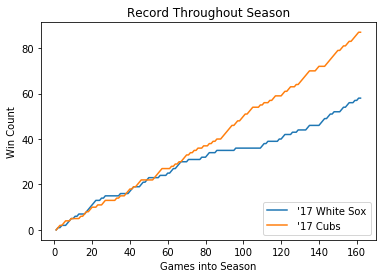

In [25]:
# create a numeric indicator of a win and take cumulative sum of wins-to-date at each point in the season
sox['win-count'] = np.where(sox['W/L']=='W', 1, 0).cumsum()
cubs['win-count'] = np.where(cubs['W/L']=='W', 1, 0).cumsum()

plt.plot(sox['win-count'],label=" '17 White Sox")
plt.plot(cubs['win-count'],label=" '17 Cubs")
plt.legend(loc=4)
plt.xlabel('Games into Season')
plt.ylabel('Win Count')
plt.title('Record Throughout Season');

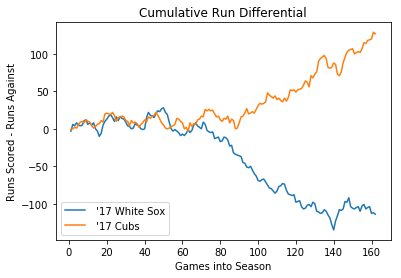

In [17]:
#Who had the largest win margins? 
sox['scorediff'] = (sox['R'] - sox['RA']).cumsum()
cubs['scorediff'] = (cubs['R'] - cubs['RA']).cumsum()
plt.plot(sox['scorediff'],label=" '17 White Sox")
plt.plot(cubs['scorediff'],label=" '17 Cubs")
plt.legend(loc=3)
plt.xlabel('Games into Season')
plt.ylabel('Runs Scored - Runs Against')
plt.title('Cumulative Run Differential');

In [41]:
from pybaseball import team_batting
batting = team_batting(start_season='2017', end_season=None, league='all', ind=1)
batting.head(5).sort_values(by=['AVG'], ascending=False)

,Season,Team,G,PA,HR,R,RBI,SB,BB%,K%,...,BABIP,AVG,OBP,SLG,wOBA,wRC+,BsR,Off,Def,WAR
1,2017.0,Astros,2313.0,6271.0,238.0,896.0,854.0,98.0,0.081,0.173,...,0.309,0.282,0.346,0.478,0.349,121.0,-0.9,161.8,-47.0,33.0
4,2017.0,Indians,2367.0,6234.0,212.0,818.0,780.0,88.0,0.097,0.185,...,0.295,0.263,0.339,0.449,0.336,107.0,9.9,61.8,-2.8,27.3
3,2017.0,Yankees,2294.0,6354.0,241.0,858.0,821.0,90.0,0.097,0.218,...,0.304,0.262,0.339,0.447,0.336,108.0,10.6,72.8,-11.6,27.9
5,2017.0,Cubs,2420.0,6283.0,223.0,822.0,785.0,62.0,0.099,0.223,...,0.302,0.255,0.338,0.437,0.331,101.0,-6.6,-1.3,66.3,26.7
2,2017.0,Dodgers,2464.0,6191.0,221.0,770.0,730.0,77.0,0.105,0.223,...,0.293,0.249,0.334,0.437,0.330,104.0,5.8,40.7,62.1,30.1


In [42]:
# select only Sox and Cubs
SoxCubs = ['White Sox','Cubs']
newbat = batting[batting.Team.isin(SoxCubs)]
newbat = newbat[['Team','AVG','G','PA','HR','R','RBI','SB','BB%','K%','OBP','SLG']]
newbat

,Team,AVG,G,PA,HR,R,RBI,SB,BB%,K%,OBP,SLG
5,Cubs,0.255,2420.0,6283.0,223.0,822.0,785.0,62.0,0.099,0.223,0.338,0.437
24,White Sox,0.256,2289.0,6059.0,186.0,706.0,670.0,71.0,0.066,0.231,0.314,0.417


In [47]:
from pybaseball import team_pitching
pitching = team_pitching(start_season='2017', end_season=None, league='all', ind=1)
pitching.head(5).sort_values(by=['ERA'], ascending=False)

,Season,Team,W,L,SV,G,GS,IP,SO,K/9,BB/9,HR/9,BABIP,LOB%,GB%,HR/FB,ERA,FIP,xFIP,WAR
5,2017.0,Yankees,91.0,71.0,36.0,639.0,162.0,1448.2,1560.0,9.69,3.13,1.19,0.280,0.745,0.462,0.142,3.75,3.88,3.82,24.4
4,2017.0,Red Sox,93.0,69.0,39.0,677.0,162.0,1482.1,1580.0,9.59,2.82,1.18,0.303,0.757,0.410,0.127,3.73,3.78,3.91,23.9
3,2017.0,Diamondbacks,93.0,69.0,43.0,675.0,162.0,1441.0,1482.0,9.26,3.22,1.07,0.294,0.742,0.481,0.131,3.67,3.80,3.86,23.2
2,2017.0,Dodgers,104.0,58.0,51.0,698.0,162.0,1444.2,1549.0,9.65,2.75,1.15,0.281,0.778,0.427,0.134,3.38,3.67,3.70,24.3
1,2017.0,Indians,102.0,60.0,37.0,659.0,162.0,1440.2,1614.0,10.08,2.54,1.02,0.303,0.775,0.441,0.130,3.30,3.33,3.41,31.7


In [48]:
newpitch = pitching[pitching.Team.isin(SoxCubs)]
newpitch = newpitch[['Team','ERA','W','L','SV','IP','SO','BB/9','HR/9','LOB%']]
newpitch

,Team,ERA,W,L,SV,IP,SO,BB/9,HR/9,LOB%
7,Cubs,3.95,92.0,70.0,38.0,1447.1,1439.0,3.44,1.21,0.742
25,White Sox,4.78,67.0,95.0,25.0,1421.2,1193.0,4.00,1.53,0.724


In [66]:
from pybaseball import bwar_bat
bwarbat = bwar_bat(return_all=True)
bwarbat.dtypes

name_common            object
age                   float64
mlb_ID                float64
player_ID              object
year_ID                 int64
team_ID                object
stint_ID                int64
lg_ID                  object
PA                    float64
G                       int64
Inn                   float64
runs_bat              float64
runs_br               float64
runs_dp               float64
runs_field            float64
runs_infield          float64
runs_outfield         float64
runs_catcher          float64
runs_good_plays       float64
runs_defense          float64
runs_position         float64
runs_position_p       float64
runs_replacement      float64
runs_above_rep        float64
runs_above_avg        float64
runs_above_avg_off    float64
runs_above_avg_def    float64
WAA                   float64
WAA_off               float64
WAA_def               float64
WAR                   float64
WAR_def               float64
WAR_off               float64
WAR_rep   

In [93]:
SoxBwar = ['CHW']
batYear = ['2017']
Soxbat = bwarbat[bwarbat.team_ID.isin(SoxBwar)]
Soxbat = Soxbat[Soxbat.year_ID.isin(batYear)]
Soxbat.to_csv("Soxbat.csv", index=False, encoding="utf-8")
Soxbat = Soxbat[['name_common','mlb_ID','team_ID','player_ID','pitcher','G','PA','salary','runs_above_avg','runs_above_avg_off','runs_above_avg_def']]
Soxbat = Soxbat.fillna('')
Soxbat.head()

,name_common,mlb_ID,team_ID,player_ID,pitcher,G,PA,salary,runs_above_avg,runs_above_avg_off,runs_above_avg_def
235,Jose Abreu,547989.0,CHW,abreujo02,N,156,675,1.0825e+07,23.5,23.5,-9.4
826,Al Alburquerque,456379.0,CHW,albural01,,0,,,,,
2029,Tim Anderson,641313.0,CHW,anderti01,N,146,606,850000,-12.3,-4.3,-0.4
2649,Cody Asche,605125.0,CHW,ascheco01,N,19,62,535000,-10.9,-10.9,-1.5
5370,Chris Beck,571476.0,CHW,beckch02,Y,5,0,,0,0,0


In [72]:
# to get mlb id
print(Soxbat["mlb_ID"][235].astype("int64"))

547989


In [83]:
# This is individual batting data
from pybaseball import statcast_batter
abreau = statcast_batter('2017-07-15', player_id = Soxbat["mlb_ID"][235].astype("int64"))

In [87]:
abreau = abreau.fillna('')
abreau.to_csv("abreau.csv", index=False, encoding="utf-8")
abreau


,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,...,release_pos_y,estimated_ba_using_speedangle,estimated_woba_using_speedangle,woba_value,woba_denom,babip_value,iso_value,launch_speed_angle,at_bat_number,pitch_number
0,SL,2017-07-15,87.5,-2.1982,5.4792,Jose Abreu,547989,621242,strikeout,swinging_strike,...,54.0768,0.000,0.000,0,1,0,0,,73,4
1,SL,2017-07-15,88.5,-2.3139,5.4066,Jose Abreu,547989,621242,,called_strike,...,53.8406,0.000,0.000,,,,,,73,3
2,SL,2017-07-15,88.2,-2.4172,5.4160,Jose Abreu,547989,621242,,swinging_strike,...,54.0338,0.000,0.000,,,,,,73,2
3,FT,2017-07-15,97.4,-2.1195,5.3026,Jose Abreu,547989,621242,,ball,...,53.4762,0.000,0.000,,,,,,73,1
4,SI,2017-07-15,94.8,-2.1022,5.9397,Jose Abreu,547989,543964,field_out,hit_into_play,...,54.2851,0.248,0.226,0,1,0,0,2,58,3
5,SI,2017-07-15,94.6,-1.9999,6.0143,Jose Abreu,547989,543964,,called_strike,...,54.2177,0.000,0.000,,,,,,58,2
6,SI,2017-07-15,91.8,-2.0500,6.0277,Jose Abreu,547989,543964,,ball,...,54.2604,0.000,0.000,,,,,,58,1
7,SI,2017-07-15,88.4,-2.1629,6.2168,Jose Abreu,547989,433587,hit_by_pitch,hit_by_pitch,...,53.9083,0.000,0.000,0.7,1,0,0,,41,1
8,CH,2017-07-15,83.7,-2.3981,6.1019,Jose Abreu,547989,433587,hit_by_pitch,hit_by_pitch,...,54.4258,0.000,0.000,0.7,1,0,0,,22,1
9,CH,2017-07-15,85.9,-2.6274,5.8621,Jose Abreu,547989,433587,field_out,hit_into_play,...,54.2907,0.099,0.093,0,1,0,0,2,6,2


In [162]:
# Working with MLB lookup service
import pandas as pd
import requests
from pandas.io.json import json_normalize
import json

In [255]:
# Getting White Sox roster
request='http://lookup-service-prod.mlb.com/json/named.roster_40.bam?team_id=145'
data= requests.get(request)
roster=data.json()
CWS=json_normalize(roster)
CWS.columns = CWS.columns.map(lambda x: x.split(".")[-1])
work = CWS['row']
df = json_normalize(work[0])
df.to_csv("roster.csv", index=False, encoding="utf-8")
df.head(3)

,bats,birth_date,college,end_date,height_feet,height_inches,jersey_number,name_display_first_last,name_display_last_first,name_first,...,pro_debut_date,start_date,starter_sw,status_code,team_abbrev,team_code,team_id,team_name,throws,weight
0,R,1987-01-29T00:00:00,,,6,3,79,Jose Abreu,"Abreu, Jose",Jose,...,2014-03-31T00:00:00,2013-10-29T00:00:00,N,A,CWS,cha,145,Chicago White Sox,R,255
1,R,1996-09-11T00:00:00,,,6,3,,Micker Adolfo,"Adolfo, Micker",Micker,...,,2017-11-20T00:00:00,N,A,CWS,cha,145,Chicago White Sox,R,200
2,R,1993-06-23T00:00:00,"East Central CC, MS",,6,1,7,Tim Anderson,"Anderson, Tim",Timothy,...,2016-06-10T00:00:00,2016-06-10T00:00:00,N,A,CWS,cha,145,Chicago White Sox,R,185


In [256]:
# Getting Abreau hitting stats
request='http://lookup-service-prod.mlb.com/json/named.sport_hitting_tm.bam?sport_hitting_tm.season=2017&game_type=%27R%27&league_list_id=%27mlb%27&player_id=547989'
data= requests.get(request)
josejson=data.json()
dfJose=json_normalize(josejson)
dfJose.columns = ['copyRight','created','ab','ao','avg','babip','bb','cs','d','end_date','g','gidp','gidp_opp','go','go_ao','h','hbp','hfly','hgnd','hldr','hpop','hr','ibb','league','league_full','league_id','league_short','lob','np','obp','ops','player_id','ppa','r','rbi','roe','sac','sb','season','sf','slg','so','sport','sport_code','sport_id','t','tb','team_abbrev','team_full','team_id','team_seq','team_short','tpa','wo','xbh','totalSize']
dfJose['player'] = Soxbat["name_common"][235]
dfJose = dfJose[['player','player_id','ab','ao','avg','babip','bb','cs','d','g','gidp','gidp_opp','go','go_ao','h','hbp','hfly','hgnd','hldr','hpop','hr','ibb','league','league_full','league_id','league_short','lob','np','obp','ops','player_id','ppa','r','rbi','roe','sac','sb','season','sf','slg','so','sport','sport_code','sport_id','t','tb','team_abbrev','team_full','team_id','team_seq','team_short','tpa','wo','xbh']]
dfJose.to_csv("abreauHitting.csv", index=False, encoding="utf-8")
dfJose

,player,player_id,ab,ao,avg,babip,bb,cs,d,g,...,t,tb,team_abbrev,team_full,team_id,team_seq,team_short,tpa,wo,xbh
0,Jose Abreu,547989,621,158,.304,.330,35,0,43,156,...,6,343,CWS,Chicago White Sox,145,1,Chi White Sox,675,1,82


In [80]:
#from pybaseball import statcast
#CWS = statcast('2017-08-01', '2017-08-30', team='CWS')
# This is pitching info